In [24]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import cache
import math
from scipy.stats import kendalltau

In [25]:
type Node = int

In [26]:
DATASET_PATH = "../datasets/ca_hepth.txt"

In [27]:
df = pd.read_csv(DATASET_PATH, sep="\t", names=["source", "target"])

In [28]:
df.head()

,source,target
0,24325,24394
1,24325,40517
2,24325,58507
3,24394,3737
4,24394,3905


In [29]:
vis_graph = nx.from_pandas_edgelist(df.head(10))
graph = nx.from_pandas_edgelist(df.sample(2500))
full_graph = nx.from_pandas_edgelist(df)

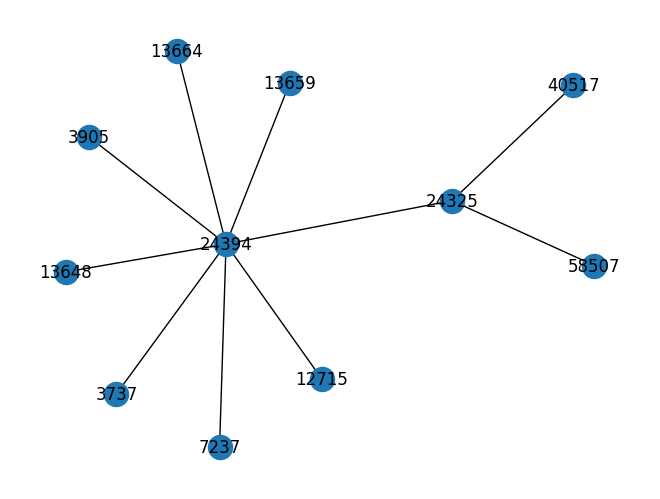

In [30]:
nx.draw(vis_graph, pos=nx.spring_layout(vis_graph, iterations=100, seed=1721), font_weight='light', with_labels=True)

In [31]:
@cache
def all_kshell_values(graph: nx.Graph) -> dict[Node, int]:
    return nx.core_number(graph)

def kshell(graph: nx.Graph, node: Node) -> int:
    return all_kshell_values(graph)[node]

@cache
def all_iteration_kshell_values(graph: nx.Graph) -> dict[Node, int]:
    iks = {}
    remaining_nodes = set(graph.nodes)
    k = 1

    while remaining_nodes:
        shell = [node for node in remaining_nodes if graph.degree(node) <= k]

        while shell:
            for node in shell:
                iks[node] = k
                graph.remove_node(node)

            remaining_nodes -= set(shell)
            shell = [node for node in remaining_nodes if graph.degree(node) <= k]

        k += 1

    return iks

def iter_kshell(graph: nx.Graph, node: Node) -> int:
    return all_iteration_kshell_values(graph)[node]

def max_iter_kshell(graph: nx.Graph) -> int:
    return max(all_iteration_kshell_values(graph).values())

def min_iter_kshell(graph: nx.Graph) -> int:
    return min(all_iteration_kshell_values(graph).values())

def max_kshell(graph: nx.Graph):
    return max(all_kshell_values(graph).values())

def min_kshell(graph: nx.Graph):
    return min(all_kshell_values(graph).values())


In [32]:
def gravity_centrality(graph: nx.Graph, node: Node) -> float:
    influence_radius = 3
    acc = 0
    neighbors = set()
    path_lengths = {}

    for i in graph.nodes:
        if i != node:
            try:
                distance = nx.shortest_path_length(graph, i, node)
                path_lengths[(i, node)] = distance
                path_lengths[(node, i)] = distance
            except nx.NetworkXNoPath:
                pass


    for i in graph.nodes:
        path_length = path_lengths.get((i, node))
        if i != node and path_length and path_lengths[(i, node)] <= influence_radius:
            neighbors.add(i)

    for neighbor in neighbors:
        num = kshell(graph, node) * kshell(graph, neighbor)
        distance = path_lengths[(neighbor, node)]
        acc = num / distance

    return acc

In [33]:
def grav_coeff(graph: nx.Graph, i: Node, j: Node) -> float:
    denom = max_iter_kshell(graph) - min_iter_kshell(graph)
    denom = 1 if denom == 0 else denom
    g = np.power(np.e, (iter_kshell(graph, i) - iter_kshell(graph, j)) / denom)
    return g

In [34]:
def gravitational_force(graph: nx.Graph, i: Node, j: Node) -> float:
    degree_prod = graph.degree(i) * graph.degree(j)
    distance = nx.shortest_path_length(graph, i, j)
    distance = 1 if distance == 0 else distance

    g = grav_coeff(graph, i, j)

    return g * degree_prod / np.square(distance)

In [35]:
def delta(graph: nx.Graph, i: Node, s: Node) -> float:
    denom = max_iter_kshell(graph) - min_iter_kshell(graph)
    denom = 1 if denom == 0 else denom

    power = (iter_kshell(graph, s) - iter_kshell(graph, i)) / denom
    return np.sqrt(np.abs(np.pow(np.e, power)))

In [36]:
def radius_of_influence(graph: nx.Graph, i: Node, s: Node, d: float | None) -> float | int:
    if d is None:
        d = delta(graph, i, s)

    try:
        distance = nx.shortest_path_length(graph, i, s)
    except nx.NetworkXNoPath:
        distance = 0
    degree = nx.degree(graph, i)
    degree = 1 if degree == 0 else degree
    degree_quotient = np.abs(nx.degree(graph, s) / degree)

    return distance / (1 + (np.sqrt(degree_quotient) * d))


In [37]:
def calculate_ground_truth_influence(graph: nx.Graph) -> dict[int, int]:
    ground_truth = {}
    for node in graph.nodes():
        ground_truth[node] = nx.degree_centrality(graph)[node]
    return ground_truth


def kendall_tau_radius_decision(graph: nx.Graph, radius_map: dict[int, list[float]]) -> dict[int, float]:
    ground_truth = calculate_ground_truth_influence(graph)
    ground_truth_list = np.array(list(ground_truth.values()))

    best_tau = -1
    best_delta = None

    for delta in range(17 + 1 - 6):
        radius_list = map(lambda x: x[delta], radius_map.values())
        influence_values = np.array(list(radius_list))

        tau, _ = kendalltau(ground_truth_list, influence_values)

        if tau > best_tau:
            best_tau = tau
            best_delta = delta

    best_radius_list = list(map(lambda x: (x[0], x[1][best_delta]), radius_map.items()))
    best_radius_map = {}

    for node, radius in best_radius_list:
        best_radius_map[node] = radius

    return best_radius_map

In [38]:
def eigenvalue_decomposition(graph: nx.Graph) -> list[list[float]]:
    A = nx.to_numpy_array(graph)
    eigenvalues, eigenvectors = np.linalg.eig(A)

    D = np.diag(eigenvalues)

    Q = eigenvectors
    Q_inv = np.linalg.inv(Q)

    A = Q @ D @ Q_inv

    return A

In [39]:
def comm_network_matrix(graph: nx.Graph) -> list[list[float]]:
    try:
        diam = nx.diameter(graph)
    except nx.NetworkXError:
        diam = max([max(j.values()) for (i,j) in nx.shortest_path_length(graph)])

    A = eigenvalue_decomposition(graph)
    X = A

    for i in range(1, diam + 1):
        X += (1 / math.factorial(i)) * A

    return np.real(X)

In [40]:
def normalized_comm_network_matrix(graph: nx.Graph) -> list[list[float]]:
    X = comm_network_matrix(graph)

    X_max = np.max(X)
    X_min = np.min(X)

    return (X - X_min) / (X_max - X_min)

In [41]:
@cache
def node_to_index(graph: nx.Graph) -> dict[int, int]:
    return {node: i for i, node in enumerate(graph.nodes())}

In [42]:
def cagm_float(graph: nx.Graph, i: Node, radius: float, norm_comm_matrix: list[list[float]]) -> float:
    integer_radius = int(np.floor(radius))
    fractional_radius = radius - integer_radius
    cagm_value_floor = 1
    cagm_value_ceil = 1
    node_to_idx = node_to_index(graph)

    # Sum influence for neighbors within integer radius
    neighbors = nx.single_source_shortest_path_length(graph, i, cutoff=integer_radius).keys()
    for y in neighbors:
        if y != i:
            i_idx = node_to_idx[i]
            y_idx = node_to_idx[y]
            influence_probability = norm_comm_matrix[i_idx][y_idx]

            force = gravitational_force(graph.copy(), i, y)
            cagm_value_floor += influence_probability * (force + fractional_radius)

    # Add fractional influence for neighbors at ⌈R_i⌉
    fractional_neighbors = [k for k, v in nx.single_source_shortest_path_length(graph, i).items() if v == integer_radius + 1]
    for w in fractional_neighbors:
        if w != i:
            i_idx = node_to_idx[i]
            w_idx = node_to_idx[w]
            influence_probability = norm_comm_matrix[i_idx][w_idx]

            force = gravitational_force(graph.copy(), i, w)
            cagm_value_ceil += influence_probability * force

    return cagm_value_floor * cagm_value_ceil

def cagm_int(graph: nx.Graph, i: Node, radius: float, norm_comm_matrix: list[list[float]]) -> float:
    radius = int(np.floor(radius))
    cagm_value = 0
    node_to_idx = node_to_index(graph)

    neighbors = nx.single_source_shortest_path_length(graph, i, cutoff=radius).keys()
    for y in neighbors:
        if y != i:
            i_idx = node_to_idx[i]
            y_idx = node_to_idx[y]
            influence_probability = norm_comm_matrix[i_idx][y_idx]

            force = gravitational_force(graph.copy(), i, y)
            cagm_value += influence_probability * force

    return cagm_value

In [43]:
def get_farthest_node(graph: nx.Graph, node: Node) -> Node:
    lengths = nx.single_source_shortest_path_length(graph, node)
    farthest_node = max(lengths, key=lengths.get)

    return farthest_node

In [44]:
def cagm_algo_ranking(graph: nx.Graph, dataset_name: str):
    radius_delta_map = {}
    for i in graph.nodes():
        radius_delta_map[i] = []

        s = get_farthest_node(graph, i)
        # s = i
        # while s == i:
        #     s = np.random.choice(graph.nodes())

        for delta in range(6, 17 + 1):
            delta = delta / 10

            radius = radius_of_influence(graph, i, s, delta)
            radius_delta_map[i].append(radius)

    radius_map = kendall_tau_radius_decision(graph, radius_delta_map)
    X = normalized_comm_network_matrix(graph.copy())

    nodes = []
    cagm_values = []

    for i in graph.nodes():
        radius = radius_map[i]

        # If integer
        cagm = None
        if radius % 1 == 0:
            cagm = cagm_int(graph.copy(), i, radius, X)
        else:
            cagm = cagm_float(graph.copy(), i, radius, X)

        print(f"CAGM(Node {i}): {cagm}")
        nodes.append(i)
        cagm_values.append(cagm)

    output_df = pd.DataFrame({"Node": nodes, "CAGM value": cagm_values})
    output_df.to_csv(f"../outputs/{dataset_name}.csv", index=False)


In [45]:
G = nx.karate_club_graph()
cagm_algo_ranking(G, "karate_out")

CAGM(Node 0): 562.6320536692144
CAGM(Node 1): 275.3049472732515
CAGM(Node 2): 369.43544835947785
CAGM(Node 3): 125.59834981702866
CAGM(Node 4): 23.374136046759038
CAGM(Node 5): 42.87837707941353
CAGM(Node 6): 41.10205126590661
CAGM(Node 7): 74.62820622180833
CAGM(Node 8): 143.62125841640025
CAGM(Node 9): 7.685155870036573
CAGM(Node 10): 20.175064202824238
CAGM(Node 11): 3.5226018823184644
CAGM(Node 12): 6.063595771400322
CAGM(Node 13): 139.33554413068347
CAGM(Node 14): 11.927683039993031
CAGM(Node 15): 17.178899888617497
CAGM(Node 16): 6.270359247216136
CAGM(Node 17): 7.071401212837537
CAGM(Node 18): 8.143372245747386
CAGM(Node 19): 21.789492984403473
CAGM(Node 20): 9.30207461568075
CAGM(Node 21): 8.41064545840655
CAGM(Node 22): 12.661136067182445
CAGM(Node 23): 98.68125185756735
CAGM(Node 24): 14.59145151460254
CAGM(Node 25): 33.754331600633826
CAGM(Node 26): 10.0542610815774
CAGM(Node 27): 55.23092355351563
CAGM(Node 28): 23.354846322532126
CAGM(Node 29): 50.16838170166917
CAGM(Node 

In [46]:
print(graph)

Graph with 3282 nodes and 2444 edges


In [47]:
cagm_algo_ranking(graph, "ca_hepth_out")

CAGM(Node 26176): 109.40137217676549
CAGM(Node 29595): 3113.971719557251
CAGM(Node 55961): 2.0060469587504706
CAGM(Node 62313): 3.0120739217025854
CAGM(Node 67851): 16.867839829116097
CAGM(Node 3769): 4.610796641733162
CAGM(Node 46357): 2.0060469587504706
CAGM(Node 42999): 3.0120341665537667
CAGM(Node 53268): 3.012027974640815
CAGM(Node 64640): 2.0060469587504706
CAGM(Node 46557): 25.342575091747545
CAGM(Node 16212): 4.159878876645994
CAGM(Node 53439): 3.0120950306131196
CAGM(Node 5888): 2.0060469587504706
CAGM(Node 58552): 1.5030234793752353
CAGM(Node 3359): 1.5030234793752353
CAGM(Node 8307): 85.22288136771257
CAGM(Node 23687): 68.80108909272731
CAGM(Node 25844): 1.5030234793752353
CAGM(Node 28360): 1.5030234793752353
CAGM(Node 61292): 7.960524804052708
CAGM(Node 65091): 10.904655126050404
CAGM(Node 7821): 1.5030234793752353
CAGM(Node 575): 1.5030234793752353
CAGM(Node 44287): 2.5803864554707387
CAGM(Node 66474): 4.018140876251412
CAGM(Node 30545): 53.7052987971082
CAGM(Node 28857): 